In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Размер train:", train.shape)
print("Размер test:", test.shape)
print("\nУникальные значения:")
print("Магазины:", train['store'].unique())
print("Товары:", train['product'].unique())
print("\nПериод данных:")
print("Train:", train['Date'].min(), "-", train['Date'].max())
print("Test:", test['Date'].min(), "-", test['Date'].max())
print("\nСтатистика продаж:")
print(train['number_sold'].describe())

Размер train: (230090, 4)
Размер test: (25550, 4)

Уникальные значения:
Магазины: [0 1 2 3 4 5 6]
Товары: [0 1 2 3 4 5 6 7 8 9]

Период данных:
Train: 2010-01-01 - 2018-12-31
Test: 2019-01-01 - 2019-12-31

Статистика продаж:
count    230090.000000
mean        780.926107
std         204.096737
min         238.000000
25%         722.000000
50%         835.000000
75%         914.000000
max        1205.000000
Name: number_sold, dtype: float64


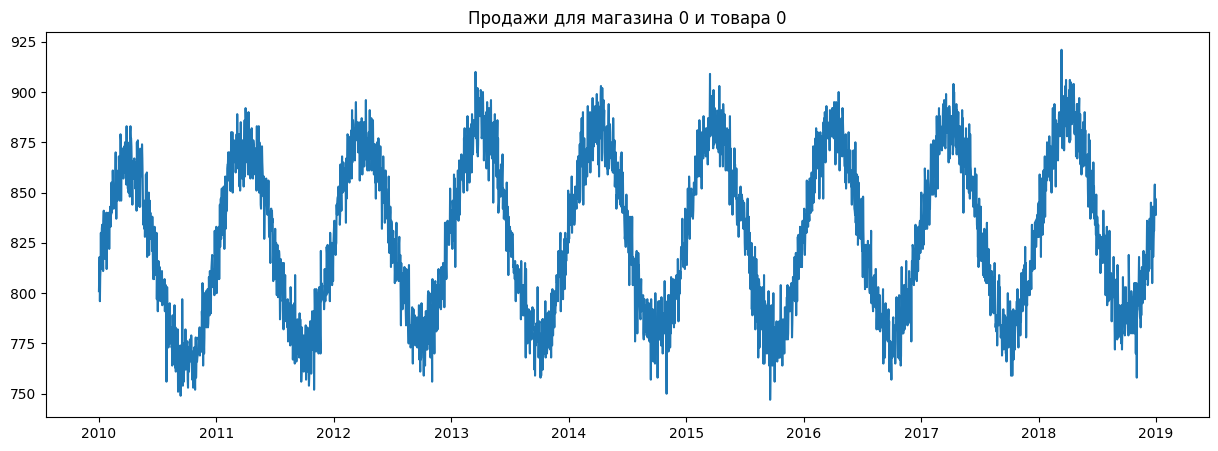

<ipython-input-2-68bc3c234c17>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['month'] = sample['Date'].dt.month


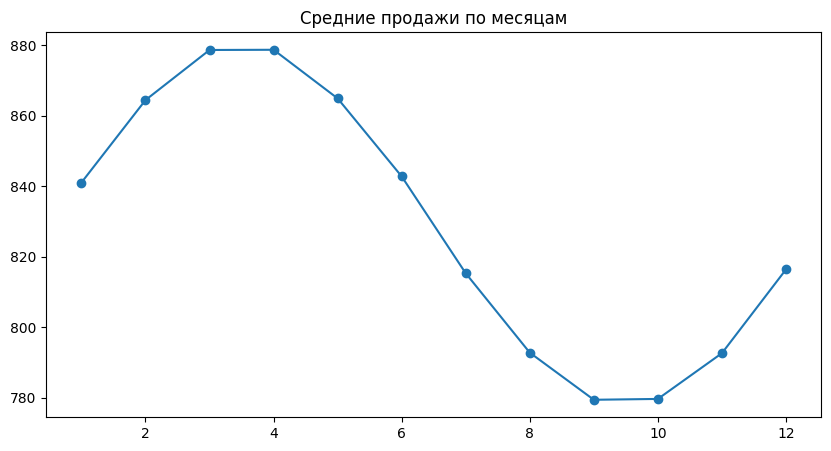

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

store_id = 0
product_id = 0
sample = train[(train['store'] == store_id) & (train['product'] == product_id)]

plt.figure(figsize=(15,5))
plt.plot(sample['Date'], sample['number_sold'])
plt.title(f'Продажи для магазина {store_id} и товара {product_id}')
plt.show()

sample['month'] = sample['Date'].dt.month
monthly_avg = sample.groupby('month')['number_sold'].mean()
plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Средние продажи по месяцам')
plt.show()

In [5]:
# Подготовка данных для SARIMA
store_id = 0
product_id = 0

# Выберем один ряд и отсортируем по дате
ts_data = train[(train['store'] == store_id) &
                (train['product'] == product_id)].sort_values('Date')

# Создадим Series с датой как индексом
ts = pd.Series(ts_data['number_sold'].values, index=ts_data['Date'])

# Проверим стационарность ряда
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts.values)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.051464907455925
p-value: 1.753642908801145e-05


In [7]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


так как сезонность годовая, будет брать по неделям. Идеально было бы 365, но это очень долго вычисляется. Но нужно данные с аггрегировать по неделям.

Перебираем комбинации параметров...


100%|██████████| 5/5 [01:52<00:00, 22.47s/it]



Лучшие параметры: SARIMA(1, 1, 1)x(0, 1, 1, 52)

Метрики качества:
MAPE: 0.0146
RMSE: 14.1580
R2: 0.8281


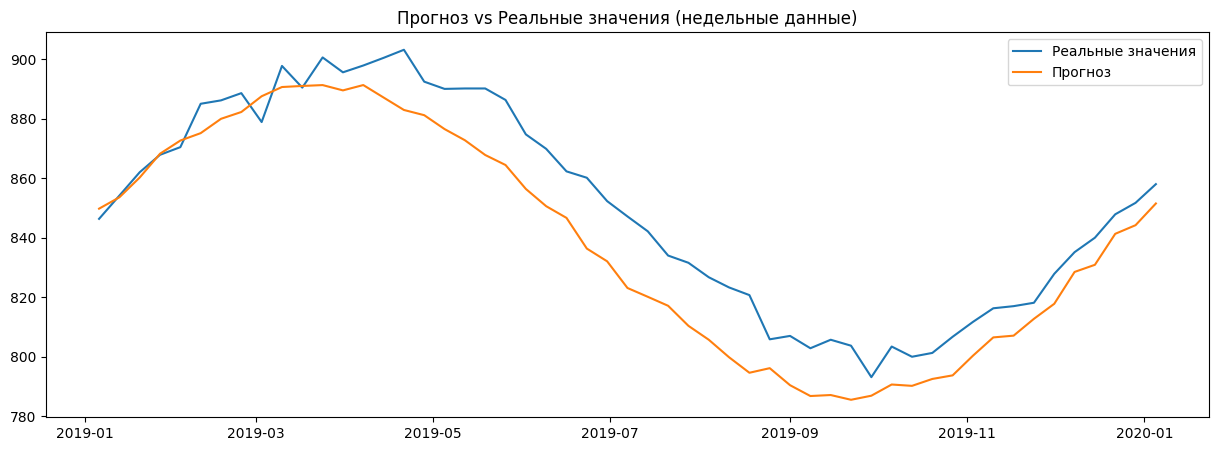

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def prepare_data(train, test, store_id=0, product_id=0):
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])

    train_sample = train[(train['store'] == store_id) & (train['product'] == product_id)].copy()
    test_sample = test[(test['store'] == store_id) & (test['product'] == product_id)].copy()

    train_weekly = train_sample.set_index('Date')['number_sold'].resample('W').mean()
    test_weekly = test_sample.set_index('Date')['number_sold'].resample('W').mean()

    return train_weekly, test_weekly

def select_best_model(train_data, test_data):
    param_combinations = [
        ((1,1,1), (1,1,1,52)),
        ((1,1,0), (1,1,1,52)),
        ((2,1,1), (1,1,1,52)),
        ((1,1,1), (0,1,1,52)),
        ((1,1,1), (1,1,0,52))
    ]

    best_aic = float('inf')
    best_params = None
    best_model = None

    print("Перебираем комбинации параметров...")
    for order, seasonal_order in tqdm(param_combinations):
        try:
            model = SARIMAX(
                train_data,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (order, seasonal_order)
                best_model = results

        except:
            continue

    print(f'\nЛучшие параметры: SARIMA{best_params[0]}x{best_params[1]}')

    forecast = best_model.get_forecast(steps=len(test_data))
    return forecast.predicted_mean, best_params, best_model

def evaluate_model(test_data, predictions):
    mape = mean_absolute_percentage_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    r2 = r2_score(test_data, predictions)

    print('\nМетрики качества:')
    print(f'MAPE: {mape:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2:.4f}')

    plt.figure(figsize=(15, 5))
    plt.plot(test_data.index, test_data, label='Реальные значения')
    plt.plot(test_data.index, predictions, label='Прогноз')
    plt.title('Прогноз vs Реальные значения (недельные данные)')
    plt.legend()
    plt.show()

    return mape, rmse, r2

store_id = 0
product_id = 0

predictions, best_params, best_model = select_best_model(train_weekly, test_weekly)
metrics = evaluate_model(test_weekly, predictions)


In [22]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

def analyze_residuals(model, test_data, predictions):
    residuals = pd.Series(test_data - predictions, index=test_data.index)

    plt.figure(figsize=(15, 10))

    plt.subplot(311)
    residuals.plot()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Остатки во времени")

    plt.subplot(312)
    plt.hist(residuals.values, bins=30, density=True)
    plt.title("Распределение остатков")

    plt.subplot(313)
    sm.graphics.tsa.plot_acf(residuals.values, lags=20, alpha=0.05)
    plt.title("Автокорреляция остатков")

    plt.tight_layout()
    plt.show()

    print("\nСтатистики остатков:")
    print(f"Среднее: {residuals.mean():.4f}")
    print(f"Стандартное отклонение: {residuals.std():.4f}")
    print(f"Минимум: {residuals.min():.4f}")
    print(f"Максимум: {residuals.max():.4f}")

    adf_test = adfuller(residuals.dropna())
    print(f"\nТест Дики-Фуллера на стационарность:")
    print(f"p-value: {adf_test[1]:.4f}")

    return residuals

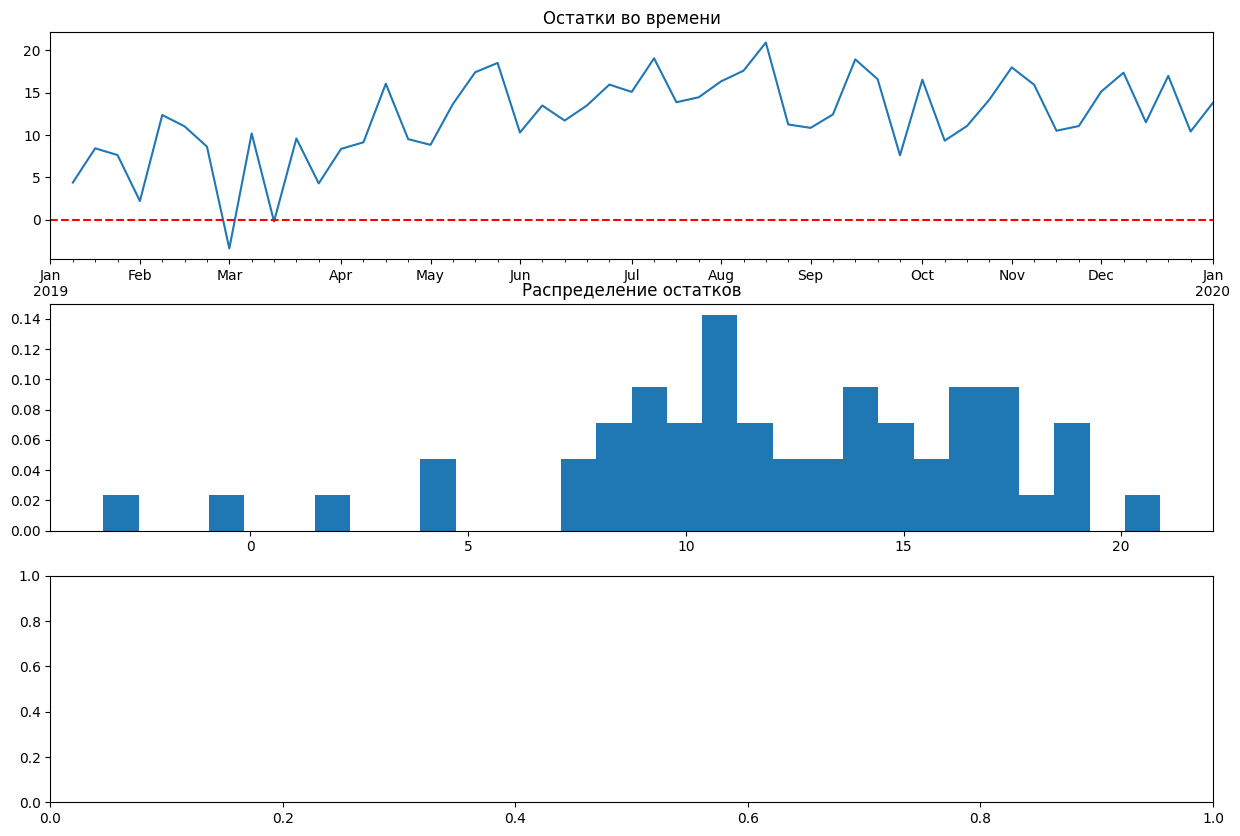

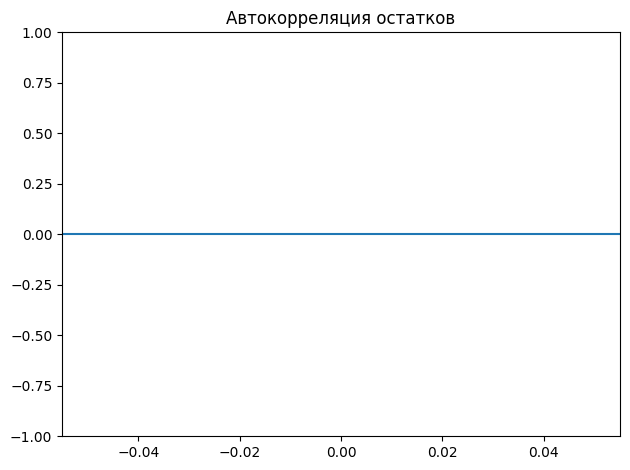


Статистики остатков:
Среднее: 12.0747
Стандартное отклонение: 4.9436
Минимум: -3.3794
Максимум: 20.8935

Тест Дики-Фуллера на стационарность:
p-value: 0.0000


In [23]:
residuals_analysis = analyze_residuals(best_model, test_weekly, predictions)

Стационарность остатков:
p-value = 0.0000 < 0.05 значит остатки стационарны, это хорошо, если правильно считается
Это говорит о том, что модель хорошо поймала основные паттерны данных

Базовые статистики:
Среднее = 12.0747 ≠ 0 - это не очень хорошо =>
Модель систематически недооценивает значения (bias)
Стандартное отклонение = 4.94 относительно небольшое


Размах (от -3.38 до 20.89) показывает асимметрию ошибок